<a href="https://colab.research.google.com/github/AnthonyTsiantisUND/CPEG-CAPSTONE/blob/main/MyowareAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
import os

try:
    import google.colab
    REPO_URL = "https://github.com/AnthonyTsiantisUND/CPEG-CAPSTONE.git"
    REPO_NAME = "CPEG-CAPSTONE"
    # DATA_FOLDER = "emg_data" # transition
    DATA_FOLDER = "emg_new" # steady state


    # Clone repo if not already present
    if not os.path.exists(REPO_NAME):
        !git clone {REPO_URL}
    os.chdir(f"{REPO_NAME}/{DATA_FOLDER}")
    print("Current directory:", os.getcwd())

except ImportError:
    pass

Cloning into 'CPEG-CAPSTONE'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 122 (delta 58), reused 106 (delta 48), pack-reused 0 (from 0)
Receiving objects: 100% (122/122), 3.24 MiB | 12.83 MiB/s, done.
Resolving deltas: 100% (58/58), done.
Current directory: /content/CPEG-CAPSTONE/emg_data/CPEG-CAPSTONE/emg_data/CPEG-CAPSTONE/emg_data/CPEG-CAPSTONE/emg_data/CPEG-CAPSTONE/emg_data/CPEG-CAPSTONE/emg_data/CPEG-CAPSTONE/emg_new/CPEG-CAPSTONE/emg_new/CPEG-CAPSTONE/emg_data/CPEG-CAPSTONE/emg_new/CPEG-CAPSTONE/emg_data/CPEG-CAPSTONE/emg_new


In [80]:
# ---- Load CSV data ----
all_files = [f for f in os.listdir() if f.endswith(".csv")]
print("Found CSV files:", all_files)

# Concatenate them into a single DataFrame
data = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
print("Data loaded. Shape:", data.shape)

Found CSV files: ['closed_fist_1.csv', 'flat_hand_7.csv', 'closed_fist_2.csv', 'flat_hand_6.csv', 'closed_fist_7.csv', 'closed_fist_3.csv', 'flat_hand_8.csv', 'flat_hand_5.csv', 'flat_hand_3.csv', 'closed_fist_6.csv', 'closed_fist_8.csv', 'flat_hand_9.csv', 'closed_fist_5.csv', 'flat_hand_2.csv', 'flat_hand_1.csv', 'flat_hand_4.csv', 'closed_fist_4.csv']
Data loaded. Shape: (106545, 9)


In [81]:
## extract features

import numpy as np
import pandas as pd

# keep useful columns
data = data[['timestamp', 'label', 'value']]
data['timestamp'] = pd.to_datetime(data['timestamp'])

print("Unique gestures:", data['label'].unique())
print("Samples per label:")
print(data['label'].value_counts())

# get featurs
def extract_features(data, window_size=200):
    features, labels = [], []

    for label, group in data.groupby('label'):
        values = group['value'].values
        for i in range(0, len(values) - window_size, window_size):
            window = values[i:i+window_size]
            feats = {
                'rms': np.sqrt(np.mean(window**2)),
                'mean_abs': np.mean(np.abs(window)),
                'var': np.var(window),
                'zero_crossings': ((window[:-1] * window[1:]) < 0).sum(),
            }
            features.append(feats)
            labels.append(label)

    X = pd.DataFrame(features)
    y = np.array(labels)
    return X, y

X, y = extract_features(data)
print(f"Extracted {len(X)} samples across {len(np.unique(y))} gestures.")

# get CSV files
X.to_csv('features.csv', index=False)
np.savetxt('labels.csv', y, delimiter=',', fmt='%s')

# print number of CSV files
print("Number of CSV files:", len(os.listdir()))


Unique gestures: ['closed_fist' 'flat_hand']
Samples per label:
label
flat_hand      56426
closed_fist    50119
Name: count, dtype: int64
Extracted 532 samples across 2 gestures.
Number of CSV files: 36


In [82]:
## train/ test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [83]:
# train model

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = SVC(kernel='rbf', C=1, gamma='scale')
clf.fit(X_train_scaled, y_train)


SVC(C=1)

              precision    recall  f1-score   support

 closed_fist       1.00      1.00      1.00        50
   flat_hand       1.00      1.00      1.00        57

    accuracy                           1.00       107
   macro avg       1.00      1.00      1.00       107
weighted avg       1.00      1.00      1.00       107



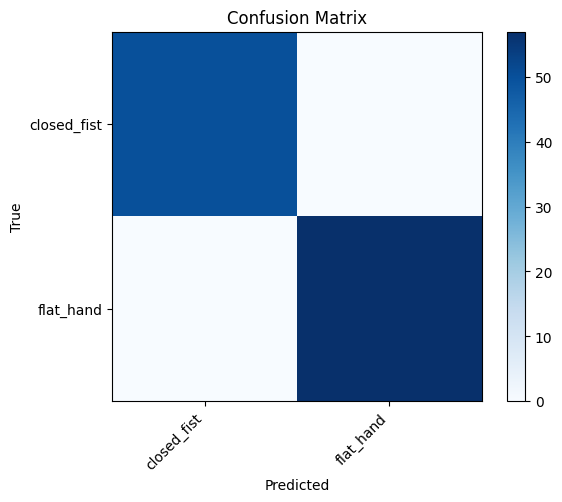

In [84]:
# confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks(np.arange(len(np.unique(y))))
ax.set_yticks(np.arange(len(np.unique(y))))
ax.set_xticklabels(np.unique(y))
ax.set_yticklabels(np.unique(y))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.colorbar(im)
plt.show()
